# Imports <a class="anchor" id="imports"></a>

I am surpressing all warnings, so that things such as "FutureWarning" for soon-to-be-deprecated sklearn modules no longer pop up all the time, to make notebook look nice.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import math
import pickle
import statistics
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
pd.set_option("display.precision", 3)
pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline

from pipeline_modules import average_metrics_pipeline
from pipeline_modules import classification_reports_pipeline
from pipeline_modules import roc_curve_pipeline

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier

from yellowbrick.model_selection import FeatureImportances

# Table of Contents

0. [Imports](#imports)
1. [Goal and Context](#goal)
2. [Importing Data](#importing-data)
3. [Class Imbalance](#class-imbalance)
4. [Choosing Scoring Metric](#metric)
5. [Train-Test Splitting](#train-test)
6. [Modeling Pipeline](#pipeline)
    
7. [Model Selection](#selection)
8. [Model Optimization](#optimization)
    * [Hyperparameter Tuning](#tuning)
    * [Class Weight Adjustment](#weights)
    * [Threshold Tuning](#threshold)
    * [Feature Engineering](#feature)

# Goal <a class="anchor" id="goal"></a>
The goal of this project is to use machine learning classification methods to determine what genre of yoga a given yoga class most closely fall into, based on the poses practiced in that class. 

### Motivation:

This problem and its results will be interesting and important for several reasons. There is a great deal of subjectivity in classifying a yoga sequence, it is ultimately up to the yoga teacher to determine what genre their class most closely falls into; but this can be hard to do when the genres themselves are somewhat ambiguous and have a lot of overlap. It is nonetheless important for yoga teachers to advertise their the classes they are offering under the accurate classification, so that students coming to the class can know what to expect. 

By trying to accurately predict a type of yoga based solely on what positions are practiced, I am attempting to use data science to answer the question of what actually defines the various classifications of yoga, so that both students and teachers alike can have more concrete definitions and better communication. 

The end goal of this project is to create a web-based yoga sequencing application for yoga teachers, where they can create their own yoga classes from drop down menus of all 3600+ yoga poses and variations, sorted by their various features, and have their sequence analyzed to find out what genre it most closely falls into.

# Context 
The work that led up to this notebook: 

### Data Collection:

I used selenium to webscrape and have collected over 40,000 different yoga classes created by yoga teachers all over the world, from 8 different main classification of yoga genre: Vinyasa, Hatha, Gentle, Restorative, Yin, Power, Iyengar, Ashtanga, and Hatha. (I decided to exclude Bikram, though fairly popular, since in Bikram yoga the same poses are practiced in the same set order every time, so the question "what poses comprise each genre" has already been answered for this genre.) For each class, I scraped the genre classification the teacher gave it, and the poses practiced in chronological order. 

I then separately scraped information about over 3600 different individual yoga poses, including what level of difficulty each pose is, what position one is in when practicing it (sitting, standing, prone), what chakra the pose activates, what types of body movement are taking place during the pose (back-bend, twist, strength), and what base pose each pose was derived from -- since many poses practiced are variations of a smaller number of base poses, knowing what fundamental type of pose each variation comes from is important, not only for analysis of the yoga, but for ease of classification. 

### EDA:

I then combined the two dataframes (see eda_prepping notebook) to include this additional diagnostic information about each pose practiced within each class, and used one-hot encoding to simplify the categorical features of "Position", "Movement Type", "Difficulty", and "Chakra" into dummy variables of their values. 

Finally, I summed the dummy variables across all the poses in each class (see eda_feature_discovery notebook), to create counts of the total number of poses in each category in each class, and then normalized those counts to accomodate for the varying lengths of classes, by diving each feature count by the length of the class, to get ratio values -- the percentage of poses in each class which fall into each category. (Note, they do not add up to 1 because each pose can be classified into many categories at once -- for instance a twisted chair pose would have a 1 in the columns of "balance", "strength", "twist", "advanced", "standing", "heart chakra", etc. 


Now, we are ready to begin performing classification!

# Loading in DataFrame <a class="anchor" id="importing data"></a>

To summarize the above, each row in this DataFrame is a yoga class made by a yoga teacher. The values in the "class length" column indicate the total number of poses in the class, and the values in each of the other columns indicate the ratio of total poses in that class that fall into each column's category. Each column itself is a piece of diagnostic information about a yoga pose, be it it's position, difficulty, etc. 

In [4]:
# feature ratios DataFrame
f = open("df_class_ratios", "rb")
df = pickle.load(f)
f.close()

In [5]:
df.head()

,Class Number,Class Length,Back-Bend,Balance,Forward-Bend,Inversion,Meditative,Pranayama,Restorative,Side-Bend,Strength,Stretch,Twist,Beginner,Intermediate,Advanced,Forearms,Head-Shoulder-Stand,Kneeling,Prone,Side-Lying,Sitting,Standing,Supine,Toes,Crown Chakra (Sahasrara Chakra),Heart Chakra (Anahata Chakra),Root Chakra (Muladhara Chakra),Sacral Chakra (Swadisthana Chakra),Solar Plexus (Manipura Chakra),Third Eye Chakra (Ajna Chakra),Throat Chakra (Vishuddha Chakra),Class Type
0,0,53,0.094,0.245,0.245,0.170,0.000,0.000,0.132,0.057,0.358,0.698,0.189,0.660,0.151,0.019,0.0,0.0,0.019,0.208,0.0,0.302,0.208,0.094,0.0,0.132,0.038,0.057,0.170,0.170,0.038,0.057,Vinyasa
1,1,52,0.365,0.308,0.462,0.423,0.000,0.000,0.115,0.000,0.558,0.750,0.077,0.558,0.288,0.077,0.0,0.0,0.019,0.250,0.0,0.135,0.308,0.212,0.0,0.192,0.077,0.000,0.115,0.096,0.038,0.212,Vinyasa
2,2,19,0.053,0.737,0.474,0.263,0.000,0.000,0.000,0.000,0.684,0.789,0.421,0.474,0.316,0.105,0.0,0.0,0.000,0.105,0.0,0.000,0.789,0.000,0.0,0.158,0.000,0.000,0.316,0.211,0.105,0.105,Vinyasa
3,3,18,0.222,0.222,0.611,0.389,0.056,0.056,0.167,0.167,0.333,0.778,0.333,0.778,0.167,0.056,0.0,0.0,0.000,0.111,0.0,0.333,0.333,0.222,0.0,0.500,0.111,0.000,0.056,0.111,0.000,0.167,Vinyasa
4,4,79,0.101,0.165,0.329,0.241,0.000,0.000,0.114,0.051,0.354,0.557,0.114,0.759,0.114,0.000,0.0,0.0,0.013,0.304,0.0,0.127,0.329,0.101,0.0,0.215,0.063,0.000,0.165,0.190,0.063,0.114,Vinyasa


In [6]:
df.describe()

,Class Number,Class Length,Back-Bend,Balance,Forward-Bend,Inversion,Meditative,Pranayama,Restorative,Side-Bend,Strength,Stretch,Twist,Beginner,Intermediate,Advanced,Forearms,Head-Shoulder-Stand,Kneeling,Prone,Side-Lying,Sitting,Standing,Supine,Toes,Crown Chakra (Sahasrara Chakra),Heart Chakra (Anahata Chakra),Root Chakra (Muladhara Chakra),Sacral Chakra (Swadisthana Chakra),Solar Plexus (Manipura Chakra),Third Eye Chakra (Ajna Chakra),Throat Chakra (Vishuddha Chakra)
count,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,4.117e+04,4.117e+04,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,4.117e+04,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000,41169.000
mean,20605.957,35.868,0.123,0.194,0.265,0.168,0.012,0.016,0.159,0.079,0.289,0.700,0.166,0.714,0.156,0.022,2.907e-05,1.436e-04,0.014,0.185,0.003,0.228,0.278,0.182,3.859e-05,0.173,0.064,0.005,0.197,0.144,0.052,0.070
std,11902.316,23.550,0.099,0.145,0.130,0.122,0.026,0.034,0.142,0.077,0.176,0.156,0.112,0.210,0.155,0.057,1.213e-03,3.805e-03,0.031,0.133,0.016,0.168,0.214,0.165,1.446e-03,0.120,0.069,0.017,0.117,0.093,0.054,0.066
min,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000e+00,0.000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,10300.000,18.000,0.059,0.083,0.182,0.077,0.000,0.000,0.062,0.020,0.167,0.621,0.091,0.600,0.048,0.000,0.000e+00,0.000e+00,0.000,0.091,0.000,0.111,0.107,0.067,0.000e+00,0.092,0.000,0.000,0.118,0.083,0.000,0.020
50%,20599.000,30.000,0.105,0.182,0.261,0.157,0.000,0.000,0.130,0.067,0.286,0.714,0.151,0.740,0.125,0.000,0.000e+00,0.000e+00,0.000,0.173,0.000,0.200,0.273,0.152,0.000e+00,0.158,0.050,0.000,0.185,0.136,0.043,0.061
75%,30917.000,46.000,0.167,0.278,0.341,0.239,0.016,0.023,0.219,0.114,0.400,0.800,0.222,0.864,0.222,0.024,0.000e+00,0.000e+00,0.018,0.260,0.000,0.308,0.400,0.250,0.000e+00,0.232,0.094,0.000,0.265,0.196,0.081,0.100
max,41224.000,200.000,1.000,1.000,1.000,1.000,0.500,1.000,1.333,1.083,1.100,1.214,1.222,1.400,1.286,1.000,1.538e-01,5.000e-01,0.824,1.000,0.727,1.138,1.273,1.400,1.333e-01,1.167,1.000,0.333,1.000,1.000,1.000,0.786


# Class Imbalance <a class="anchor" id="class-imbalance"></a>

### Investigating Class Imbalance

In [7]:
class_names = ["Ashtanga", "Gentle", "Hatha", "Iyengar", "Power", "Restorative", "Vinyasa", "Yin"]
number_of_classes = [len(df.loc[df["Class Type"] == class_type]) for class_type in class_names]

In [8]:
print("Number of Classes of Each Type: ")
for i, x in zip(class_names, number_of_classes):
    print(i, ":", x)

Number of Classes of Each Type: 
Ashtanga : 1310
Gentle : 5466
Hatha : 12589
Iyengar : 1108
Power : 1397
Restorative : 2421
Vinyasa : 12497
Yin : 4381


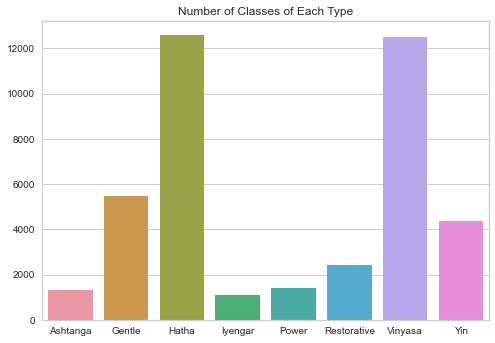

In [9]:
sns.barplot(x = class_names, y = number_of_classes)
plt.title("Number of Classes of Each Type");

The above indicates that there is clearly class imbalance amongst the yoga genres. This will need to be accomodated for. 

### Class Balancing

I will try several class balancing resampling methods to determine which is optimal, including SMOTE and ADASYN methods for oversampling the small classes. I am inclined to prefer oversampling the smaller classes rather than undersampling the larger classes for this data (Vinyasa and Hatha), since each of the 40000+ yoga sequences I collected is a completely unique sequence, all by different yoga teachers all over the world, and I really do want to include all of this input and potential discrepancies in my model to reach a true consensus/find trends across all teachers, rather than exclude any. 

*Class balancing methods will be implemented concurrently with modeling, inside the cross-validation loop (oversampled once for each fold) to prevent fitting to test/validation data and corrupting the model.*

# Scoring Metric <a class="anchor" id="metric"></a>
I need to choose which scoring metric I will prioritize in deciding which classifier is the best model for my data. This I will choose based on the above explorations of my data, paired with some indutry knowledge.  

### Some Context on the Yoga Industry
As the yoga industry currently exists, the vast majority of classes offered are labeled as either "Vinyasa' or "Hatha". I'm familiar with this phenomenon as a practitioner of yoga looking for classes to take, but it is reflected in my imbalanced dataset as well. Those two types are more commonly known terms for yoga that even non-yoga practitioners may recognize, and teachers may not be as familiar with the the nuance of the other lesser-known forms of yoga, don't think they can offer classes with those labels, or don't think people will be as likely to show up to them. Hence, far fewer classes get labeled with the other class types, even if technically the class being offered actually is more closely aligned with one of those types. 

This can be problematic for both yoga teachers and yoga practitioners. For practitioners, if the vast majority of classes have the same 2 labels, but of course vary wildly in content, you could go in expecting one thing, but recieve a class of an entirely different intensity level you did not desire, since they've been obscured to be extremely broad and non-descript terms. As a teacher, it is important to be candid about what you are actually offering. 

In choosing to label a class either Vinyasa or Hatha, the key difference is basically whether or not "Surya Namaskar A", a sun-salutation flow with a certain push-up pose called "Chaturanga" is included or not. If so, the class is called Vinyasa, and if not, Hatha. 

But the inclusion of one flow of a few poses should not determine an entire industry-dominating genre where there are so many other nuances. 

It is important for yoga teachers, if they want to find success in todays capital-driven world, to market themselves well. Part of doing this is establishing a 'brand' and offering yoga content that pracitioners will want to pay to learn. This can be better done if the yoga teachers accurately label what it is they are actually offering, and being able to offer more niche or what are perceieved as more "difficult" types of yoga could help with this immensely. 

### So, Back to Choosing A Metric...
For this reason, I want to prioritize accurately labeling the minority classes of yoga types, to help break the cycle of just lazily labeling yoga classes "Vinyasa" or "Hatha". My model should be best at accurately identifying the smaller class types, so much so that I am okay with it mislabeling some Vinyasa and Hatha classes as the other types -- because realistically, there is a lot of overlap in yoga genres (there are only so many total yoga poses, afterall), and likely some classes that I've scraped from teachers who have called them "Vinyasa" or "Hatha" may actually be better classified as something else -- the teacher just didint' know it! 

In stats terms, then, I want to choose a scoring metric which punishes falsely classifying the smaller classes as the majority classes. I am okay with false positives (classifying a common Vinyasa class a less-common Ashtanga for example) as I see an industry need for that shift, but want to punish false negatives (saying that what is actually an Ashtanga or some smaller class type is just "Vinyasa" or "Hatha", as the industry already does.) For this reason, I will choose **Recall** as my scoring metric, to minimize Type II error. I will also look at F1 score, as it balances Recall and Precision to prioritize the number of the small class I am capturing. 

# Train-Test Splitting <a class="anchor" id="train-test"></a>
Dividing into training and test sets, using stratify to assure that rows from the smaller imbalanced classes are included in the test set at the same ratio that they exist in the entire data set. 

The test sets will serve as the hold out data, and will only be tested at the very end with the finalized model. 

In [10]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Baseline Modeling & Oversampler Selection <a class="anchor" id="baseline"></a>
I first want to get a baseline understanding of how well my data can being classified with a couple of simple models, understand how much the classifiction is being negatively influenced by class imbalance, and determine which method of oversampling will be best to improve recall of minority classes. 

I will, without validation, apply K-Nearest Neighbors classification and Logistic Regression to my data, both without and then with oversampling. 

### K-Nearest Neighbors

In [12]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, np.array(y_train).ravel())
y_pred = knn.predict(X_test)
print("Training set: ", knn.score(X_train, y_train))
print("Test set: ", knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.5233338393805982
Test set:  0.4153509837260141
              precision    recall  f1-score   support

    Ashtanga       0.10      0.01      0.02       262
      Gentle       0.27      0.26      0.26      1093
       Hatha       0.37      0.49      0.42      2518
     Iyengar       0.32      0.03      0.05       222
       Power       0.21      0.02      0.04       279
 Restorative       0.42      0.19      0.26       484
     Vinyasa       0.48      0.52      0.50      2500
         Yin       0.56      0.57      0.56       876

    accuracy                           0.42      8234
   macro avg       0.34      0.26      0.26      8234
weighted avg       0.40      0.42      0.39      8234



Defining a function to visualize confusion matrices as heat maps for each model/oversampler combo: 

In [13]:
def make_heatmap(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 8))
    conf_matrix = confusion_matrix(y_test, y_pred, normalize="all")
    sns.heatmap((conf_matrix*100), annot=True, square=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("{} Confusion Matrix".format(model_name));

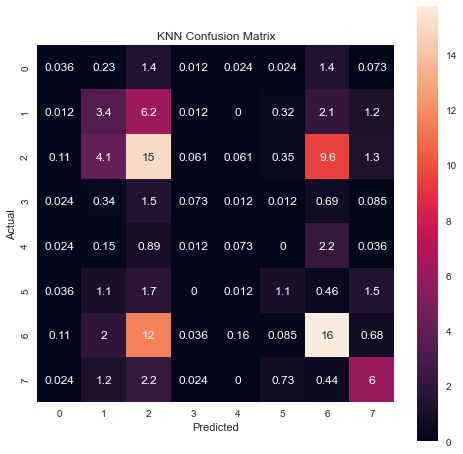

In [14]:
make_heatmap(y_test, y_pred, "KNN")

KNN has performed fairly okay as a baseline. Although the accuracy is fairly high, it definitely suffers from class imbalance issues that will need to be dealt with. There is very little recall for the smaller classes. 

Testing with class balancing, trying SMOTE first: 

In [15]:
X_smote, y_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)
knn.fit(X_smote, np.array(y_smote).ravel())
y_pred = knn.predict(X_test)
print("Training set: ", knn.score(X_smote, y_smote))
print("Test set: ", knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.7277951544037335
Test set:  0.20961865435997085
              precision    recall  f1-score   support

    Ashtanga       0.05      0.22      0.08       262
      Gentle       0.22      0.31      0.26      1093
       Hatha       0.38      0.10      0.15      2518
     Iyengar       0.06      0.28      0.10       222
       Power       0.08      0.39      0.14       279
 Restorative       0.18      0.35      0.24       484
     Vinyasa       0.50      0.13      0.21      2500
         Yin       0.47      0.47      0.47       876

    accuracy                           0.21      8234
   macro avg       0.24      0.28      0.21      8234
weighted avg       0.36      0.21      0.22      8234



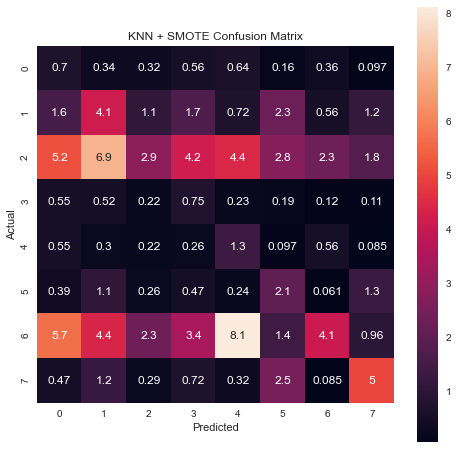

In [16]:
make_heatmap(y_test, y_pred, "KNN + SMOTE")

Woah, a pretty severe case of overfitting to the synthetic data here. While the recall of the minority classes was improved, there is very low precision across a great deal of classes, and high accuracy on the training data of over 70% is reduced to just 20% on the test data. Synthetic data may hence not be a good choice. Let's try to just randomly oversample the minority classes instead: 

In [17]:
X_ROS, y_ROS = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
knn.fit(X_ROS, np.array(y_ROS).ravel())
y_pred = knn.predict(X_test)
print("Training set: ", knn.score(X_ROS, y_ROS))
print("Test set: ", knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.7099096415450303
Test set:  0.24180228321593394
              precision    recall  f1-score   support

    Ashtanga       0.06      0.20      0.09       262
      Gentle       0.22      0.31      0.26      1093
       Hatha       0.38      0.15      0.21      2518
     Iyengar       0.06      0.19      0.09       222
       Power       0.08      0.30      0.12       279
 Restorative       0.16      0.35      0.22       484
     Vinyasa       0.51      0.21      0.30      2500
         Yin       0.45      0.45      0.45       876

    accuracy                           0.24      8234
   macro avg       0.24      0.27      0.22      8234
weighted avg       0.36      0.24      0.26      8234



This one still suffers from the same overfitting, but didn't do quite as bad on the test set. Visualized as a heat map to see improvement:

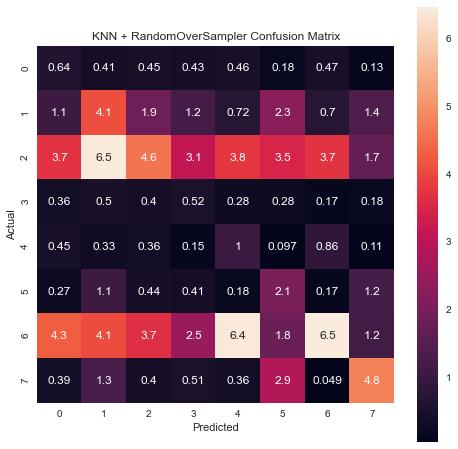

In [18]:
make_heatmap(y_test, y_pred, "KNN + RandomOverSampler")

In [19]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy="minority", random_state=42).fit_sample(X_train, y_train)
knn.fit(X_adasyn, np.array(y_adasyn).ravel())
y_pred = knn.predict(X_test)
print("Training set: ", knn.score(X_adasyn, y_adasyn))
print("Test set: ", knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.5666977055129766
Test set:  0.344911343211076
              precision    recall  f1-score   support

    Ashtanga       0.09      0.01      0.01       262
      Gentle       0.29      0.20      0.24      1093
       Hatha       0.39      0.36      0.38      2518
     Iyengar       0.05      0.47      0.09       222
       Power       0.08      0.01      0.01       279
 Restorative       0.46      0.18      0.25       484
     Vinyasa       0.50      0.42      0.46      2500
         Yin       0.58      0.52      0.55       876

    accuracy                           0.34      8234
   macro avg       0.30      0.27      0.25      8234
weighted avg       0.40      0.34      0.36      8234



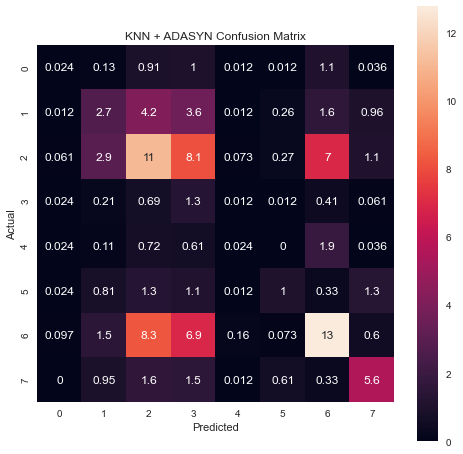

In [20]:
make_heatmap(y_test, y_pred, "KNN + ADASYN")

A huge improvement on the overfitting, with better accuracy on the test set. However, recall for the minority classes has once again decreased, which I care about most... This may be unique to KNN though. Let's try another model to see how the various oversamplers with compare. 

### Logistic Regression

In [21]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, np.array(y_train).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_train, y_train))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.4770608774859572
Test set:  0.47558902113189216
              precision    recall  f1-score   support

    Ashtanga       0.00      0.00      0.00       262
      Gentle       0.37      0.18      0.24      1093
       Hatha       0.42      0.53      0.47      2518
     Iyengar       0.50      0.03      0.05       222
       Power       1.00      0.01      0.01       279
 Restorative       0.54      0.20      0.29       484
     Vinyasa       0.51      0.68      0.58      2500
         Yin       0.58      0.66      0.62       876

    accuracy                           0.48      8234
   macro avg       0.49      0.29      0.28      8234
weighted avg       0.47      0.48      0.44      8234



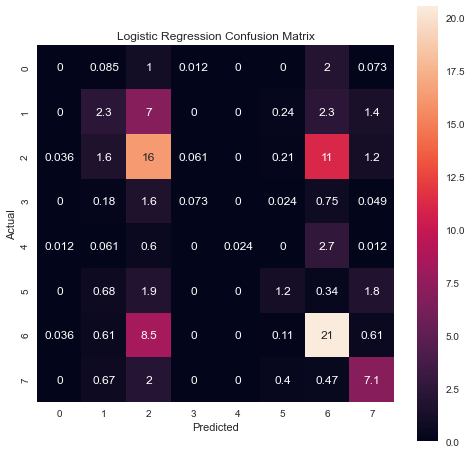

In [22]:
make_heatmap(y_test, y_pred, "Logistic Regression")

Similarly to KNN, without oversampling there is very little recall in the minority classes. It has almost zero recall in the minority classes. Trying oversampling with this model to try to improve as well: 

In [23]:
X_smote, y_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)
log_reg.fit(X_smote, np.array(y_smote).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_smote, y_smote))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.4305183199285076
Test set:  0.30337624483847464
              precision    recall  f1-score   support

    Ashtanga       0.09      0.30      0.14       262
      Gentle       0.29      0.38      0.33      1093
       Hatha       0.48      0.15      0.22      2518
     Iyengar       0.12      0.45      0.19       222
       Power       0.11      0.53      0.19       279
 Restorative       0.28      0.44      0.34       484
     Vinyasa       0.51      0.25      0.34      2500
         Yin       0.54      0.62      0.57       876

    accuracy                           0.30      8234
   macro avg       0.30      0.39      0.29      8234
weighted avg       0.42      0.30      0.31      8234



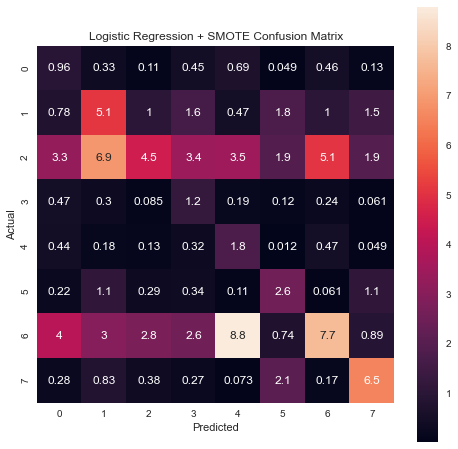

In [24]:
make_heatmap(y_test, y_pred, "Logistic Regression + SMOTE")

Hooray! Way less subject to overfitting than KNN was by oversampling, and the recall of minority classes is greatly improved. 

In [25]:
X_ROS, y_ROS = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)
log_reg.fit(X_ROS, np.array(y_ROS).ravel())
y_pred = log_reg.predict(X_test)
print("Training set: ", log_reg.score(X_ROS, y_ROS))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.39960033760301855
Test set:  0.3051979596793782
              precision    recall  f1-score   support

    Ashtanga       0.09      0.30      0.14       262
      Gentle       0.29      0.38      0.33      1093
       Hatha       0.50      0.15      0.23      2518
     Iyengar       0.12      0.45      0.19       222
       Power       0.12      0.53      0.19       279
 Restorative       0.28      0.43      0.34       484
     Vinyasa       0.50      0.25      0.34      2500
         Yin       0.54      0.62      0.58       876

    accuracy                           0.31      8234
   macro avg       0.30      0.39      0.29      8234
weighted avg       0.43      0.31      0.31      8234



Random Over Sampler is very comparable to SMOTE, but with even a little less overfitting as shown by the smaller difference in accuracy between training and test sets. Again, visualizing as a heat map:

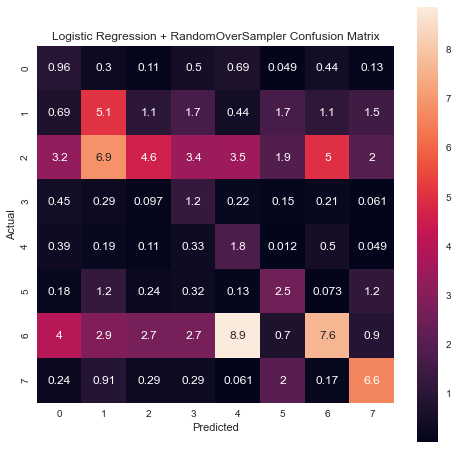

In [26]:
make_heatmap(y_test, y_pred, "Logistic Regression + RandomOverSampler")

In [27]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy="minority", random_state=42).fit_sample(X_train, y_train)
log_reg.fit(X_adasyn, np.array(y_adasyn).ravel())
y_pred = knn.predict(X_test)
print("Training set: ", log_reg.score(X_adasyn, y_adasyn))
print("Test set: ", log_reg.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Training set:  0.4551011150108636
Test set:  0.421423366529026
              precision    recall  f1-score   support

    Ashtanga       0.09      0.01      0.01       262
      Gentle       0.29      0.20      0.24      1093
       Hatha       0.39      0.36      0.38      2518
     Iyengar       0.05      0.47      0.09       222
       Power       0.08      0.01      0.01       279
 Restorative       0.46      0.18      0.25       484
     Vinyasa       0.50      0.42      0.46      2500
         Yin       0.58      0.52      0.55       876

    accuracy                           0.34      8234
   macro avg       0.30      0.27      0.25      8234
weighted avg       0.40      0.34      0.36      8234



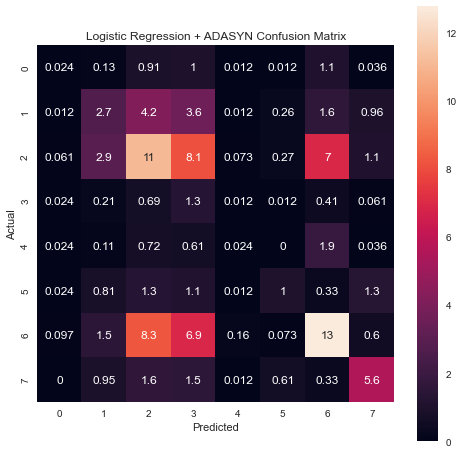

In [28]:
make_heatmap(y_test, y_pred, "Logistic Regression + ADASYN")

ADASYN again demonstrates almost no overfitting, higher accuracy, but loss of recall in the minority classes.

### Oversamplers

I'm not ready to make a final call yet on which oversampling method will be best. The heat maps demonstrate that precision-recall trade-off that will need to be made on my final model no matter the oversampler. (I want higher recall on all classes, but want to maintain a degree of precision in doing so). 

I think the best choice may depend on my final chosen model and what else I can do to balance classes and improve recall for minority classes. Moving forward, I will continue to try both RandomOverSampler and ADASYN since they've been the best so far (SMOTE just struggles from too much overfitting). 

# Model Selection Pipeline 

Armed now with a thorough understanding of my data (see eda_feature_discovery notebook for comparisons feature distribution across classes), how an example of classification models of different types perform on the raw data, and my chosen scoring metric, I am ready to optimize performance and test all the classification models on my data at once, to choose which is best. 

In the attached .py file entitled "pipeline modules", I have defined methods for comparing different models to each other. I will begin by comparing K-Nearest Neighbors, Logistic Regression, Decision Tree, Random Forest, Bernoulli Naive Bayes, and XGBoost, in their default (non-optimized) states.

### Pipeline 1: Weighted Average Metrics & Cross-Validation

The first pipeline module provides weighted averages across all 8 classes for each scoring metric, and implements cross-validation in doing so. 

I will use this as a first test to understand relative performance of all models. 


In [29]:
# instantiating XGBoost model with default parameters
XGBoost = XGBClassifier(n_estimators=30000,
                        num_class=8,
                        max_depth=3,
                        objective="binary:logistic", 
                        learning_rate=.1, 
                        subsample=1, 
                        min_child_weight=1,
                        colsample_bytree=.8
                        )

In [30]:
# defining and instantiating other models
models = {"KNN": KNeighborsClassifier(n_neighbors=10),
          "Logistic Reg": LogisticRegression(max_iter=5000), 
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "BernoulliNB": BernoulliNB(),
          "XGBoost": XGBoost
         }

Random Oversampler: 

In [31]:
for model_name, model in models.items():
    average_metrics_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

KNN :
Accuracy: 0.2464551389099742, Variance: 5.572896400432106e-06
Precision: 0.36595493989882405, Variance: 9.110368229973664e-06
Recall: 0.2464551389099742, Variance: 5.572896400432106e-06
F1 Score: 0.2643772453801303, Variance: 1.2245425620057772e-05
 
Logistic Reg :
Accuracy: 0.31164414756338243, Variance: 3.848248602068441e-05
Precision: 0.430264970344256, Variance: 3.133564292064219e-05
Recall: 0.31164414756338243, Variance: 3.848248602068441e-05
F1 Score: 0.3193458963857808, Variance: 3.057287180796863e-05
 
Decision Tree :
Accuracy: 0.33560042507970245, Variance: 4.277163416014017e-05
Precision: 0.34003845602145183, Variance: 3.107080484018196e-05
Recall: 0.33560042507970245, Variance: 4.277163416014017e-05
F1 Score: 0.3376382015726117, Variance: 3.6625653487448944e-05
 
Random Forest :
Accuracy: 0.47114012448762715, Variance: 6.1606087999814285e-06
Precision: 0.463107667263257, Variance: 8.394083539917388e-06
Recall: 0.47114012448762715, Variance: 6.1606087999814285e-06
F1 Sc

ADASYN: 

In [32]:
for model_name, model in models.items():
    average_metrics_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=42, sampling_strategy="minority"))
    print(" ")

KNN :
Accuracy: 0.3422498861393654, Variance: 4.1238972412295956e-05
Precision: 0.40109503795887125, Variance: 0.00014113188058730098
Recall: 0.3422498861393654, Variance: 4.1238972412295956e-05
F1 Score: 0.35839557495064733, Variance: 5.22253629542048e-05
 
Logistic Reg :
Accuracy: 0.41803552451799, Variance: 3.515442051107995e-05
Precision: 0.4598442916867464, Variance: 0.0002853073121113404
Recall: 0.41803552451799, Variance: 3.515442051107995e-05
F1 Score: 0.4128595496424246, Variance: 2.161570078950511e-05
 
Decision Tree :
Accuracy: 0.33602550478214666, Variance: 3.053338772246657e-05
Precision: 0.34880154832887794, Variance: 2.95643621035606e-05
Recall: 0.33602550478214666, Variance: 3.053338772246657e-05
F1 Score: 0.34160101812094834, Variance: 3.0226752683732434e-05
 
Random Forest :
Accuracy: 0.4692576286625171, Variance: 2.21371670496899e-05
Precision: 0.48036198087373266, Variance: 0.0001062245818773758
Recall: 0.4692576286625171, Variance: 2.21371670496899e-05
F1 Score: 0.

### Pipeline 2: Classification Reports 

So far, based only on average scores, it looks like the best performing models are: 
1. Random Forest
2. XGBoost
3. Logistic Regression

Furthermore, ADASYN looks to perform better than RandomOverSampler so far.

However, average metric scores, even weighted, may be misleading for my purposes. Particularly because my dataset is imbalanced, a weighted score may prioritize the larger classes and have a high score, even if it is not performing that well in the small classes. 

I care a great deal more how well each individual class is being scored. 

For this reason I will omit cross-validation, in favor of just single validation, such that I can view the classification report for each model (which are output as strings and hence can't be averaged across 5 folds) and understand the scoring metrics for each individual class. I will again try different oversampling methods, but validating on non-oversampled data so as not to overfit. 

Testing all the same models as above in their default states. 

In [33]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

KNN               precision    recall  f1-score   support

    Ashtanga       0.06      0.24      0.10       191
      Gentle       0.23      0.30      0.26       875
       Hatha       0.36      0.16      0.22      2028
     Iyengar       0.08      0.26      0.12       170
       Power       0.07      0.26      0.11       239
 Restorative       0.17      0.40      0.24       368
     Vinyasa       0.48      0.18      0.27      2014
         Yin       0.44      0.46      0.45       702

    accuracy                           0.24      6587
   macro avg       0.24      0.28      0.22      6587
weighted avg       0.35      0.24      0.26      6587

 
Logistic Reg               precision    recall  f1-score   support

    Ashtanga       0.08      0.27      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.49      0.16      0.25      2028
     Iyengar       0.09      0.33      0.14       170
       Power       0.11      0.46      0.18       239
 Rest

In [34]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, ADASYN(random_state=42, sampling_strategy="minority"))
    print(" ")

KNN               precision    recall  f1-score   support

    Ashtanga       0.17      0.01      0.02       191
      Gentle       0.28      0.19      0.23       875
       Hatha       0.37      0.35      0.36      2028
     Iyengar       0.06      0.50      0.10       170
       Power       0.08      0.00      0.01       239
 Restorative       0.39      0.20      0.27       368
     Vinyasa       0.49      0.43      0.46      2014
         Yin       0.58      0.48      0.52       702

    accuracy                           0.34      6587
   macro avg       0.30      0.27      0.25      6587
weighted avg       0.39      0.34      0.36      6587

 
Logistic Reg               precision    recall  f1-score   support

    Ashtanga       0.00      0.00      0.00       191
      Gentle       0.40      0.15      0.21       875
       Hatha       0.45      0.39      0.41      2028
     Iyengar       0.07      0.52      0.12       170
       Power       0.00      0.00      0.00       239
 Rest

### Analysis: 

First off, it is clear across both models that RandomOverSampler is far preferable for my purposes than ADASYN as an oversampler. With ADASYN, I just have extremely low recall in minority classes. Even though it's average scoring metrics were higher, this was caused only by the majority classes. So: 
* I will use RandomOverSampler! 

Looking at the classification reports, the best 3 models are, in order: 
1. XGBoost
2. Logistic Regression
3. Random Forest

The same 3 models as before, but now its clear that Random Forest is actually not the best -- it has high precision in all classes, but suffers from low recall in minority classes. It's possible that this could still be improved. 

XGBoost and Logistic are about comparable. With ROS, they both have high recall of all classes and pretty good precision! 

### Pipeline 3: ROC-AUC Curves

I will now look at the ROC-AUC curves. For each model, I will plot the ROC curve for each individual class to get a visual idea of performance. 

Unfortunately, I have to exclude XGBoost from the models I will plot. After many attempts and research, it appears that XGBoost is not currently set up to accomodate to handle binarized multi-class classification. 

In [35]:
models = {"KNN": KNeighborsClassifier(n_neighbors=10),
          "Logistic Reg": LogisticRegression(max_iter=5000), 
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "BernoulliNB": BernoulliNB()
         }

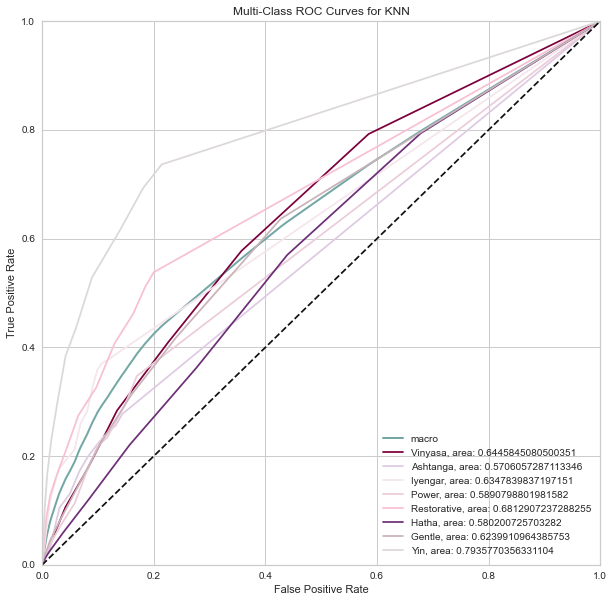

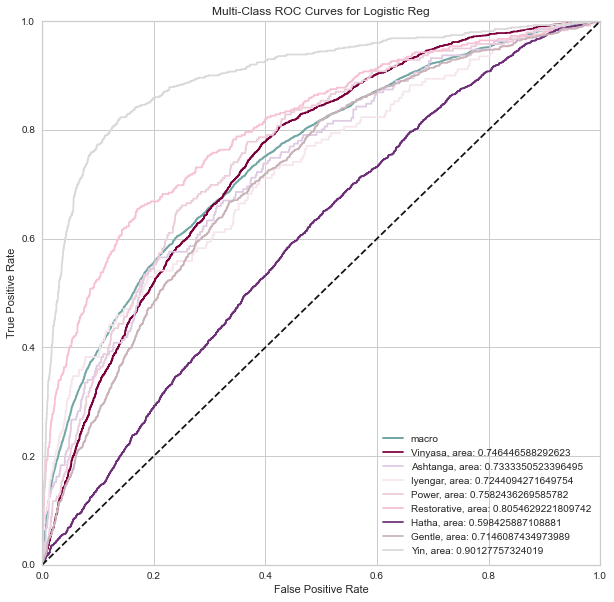

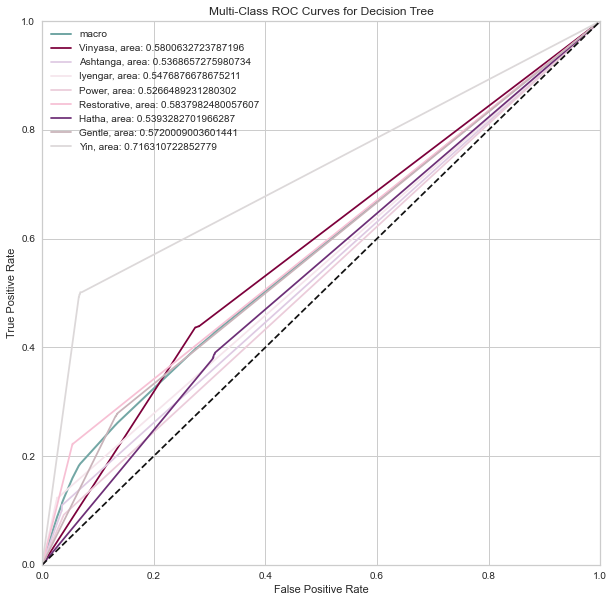

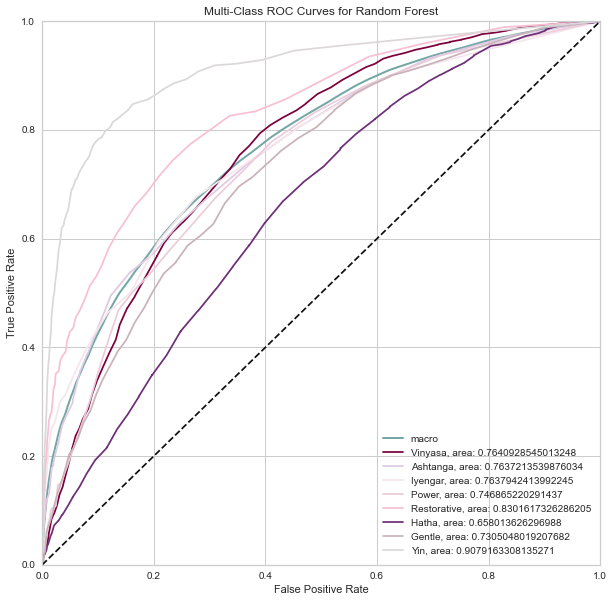

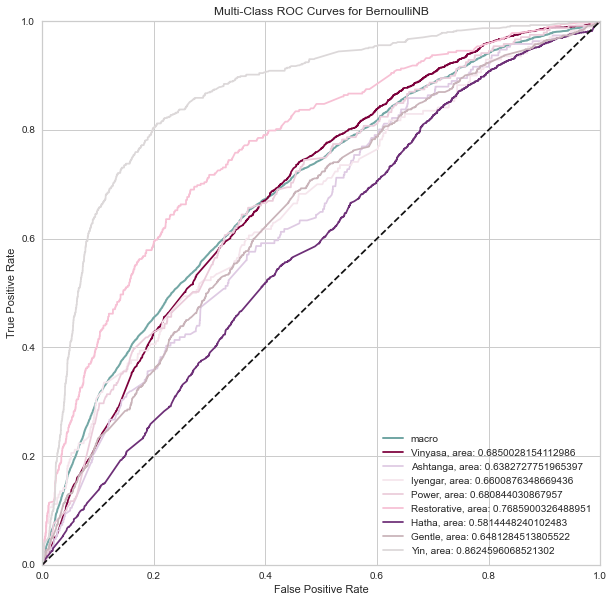

In [36]:
for model_name, model in models.items():
    roc_curve_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

### Analysis: 

Looking at the plots above, the best performing models look to be Logistic Regression and Random Forest. In each, almost all classes have a very high, good-looking AUC (including all the minority classes shown in varying shades of light pink), with the exception of Hatha -- bit this could actually be a good thing for the yoga industry! "Hatha" just means "movement" and is kind of a catch-all term for "other" classes when you don't know what to label your class. These models are essentially taking from that huge ambiguous pool, and relabeling them more accurately with other class types. 

# Model Optimization
Now that I understand how well the models are comparatively performing, I want to try to improve the performance of the best models. 

I will be optimizing the following models based on their performance thus far: 
* Logistic Regression
* Random Forest
to see which can ultimately perform best. 

While XGBoost also has performed well, the combination of not being able to visualize its ROC-AUC curve, it taking forever to run and make predictions which is not great/scalable for my web application, and the fact that I let both GridSearchCV and RandomSearchCV run on my computer for 24 hours EACH to try to hyperparameter tune and still neither one finished, has ruled this model out for me. Its just not practical to have to accomodate for those time and processing complexity issues for a project of this scope/timescale. 

### Hyperparameter Tuning
The first thing I will do is tune hyperparameters on my models. 

**Random Forest**: For Random Forest, the only real hyperparameter would be number of trees. The scikit learn default is 100, I will try a forest with 1000 to see if there is improvement. There is no real danger of overfitting a Random Forest model, so increasing this number so high isn't problematic. 

**Logistic Regression**: First I will be adding the parameter "multi_class" and trying two different options to see if either improves performance over the default Logistic Regression model! I will be running all 3 version of LogReg against Random Forest as well to compare. The two variations are: 
* "OVR" -- for OneVRest Classifier. OneVRest was used above to create ROC-AUC curves and they looked quite well, so this could be a good way to move forward with handling my multi-class problem. 
* "Multinomial" 

In [38]:
models = {"Random Forest": RandomForestClassifier(),
          "Bigger Forest": RandomForestClassifier(n_estimators=1000),
          "LogReg": LogisticRegression(max_iter=5000),
          "LogReg OVR": LogisticRegression(multi_class="ovr", max_iter=5000),
          "LogReg Multi": LogisticRegression(multi_class="multinomial", max_iter=5000)
         }

In [39]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

Random Forest               precision    recall  f1-score   support

    Ashtanga       0.43      0.08      0.14       191
      Gentle       0.33      0.28      0.30       875
       Hatha       0.42      0.48      0.45      2028
     Iyengar       0.46      0.14      0.22       170
       Power       0.38      0.03      0.06       239
 Restorative       0.46      0.26      0.34       368
     Vinyasa       0.52      0.62      0.57      2014
         Yin       0.58      0.68      0.63       702

    accuracy                           0.47      6587
   macro avg       0.45      0.32      0.34      6587
weighted avg       0.46      0.47      0.45      6587

 
Bigger Forest               precision    recall  f1-score   support

    Ashtanga       0.42      0.07      0.12       191
      Gentle       0.39      0.31      0.34       875
       Hatha       0.44      0.50      0.47      2028
     Iyengar       0.45      0.14      0.21       170
       Power       0.38      0.03      0.05     

Pretty near identical performance with these parameters changed. I'll just continue on with the defaults then. Now that I think of it Logistic Regression may have defaulted to multinomial since this is multiclass. They have exactly the same values above. 

The next hyperparameter I'll tune for Logistic Regression is the **solver** (type of algorithm). The default (what it's been using so far) is "lbfgs", but its possible another option could be better at handling this multi-class problem (I'm also decreasing max_iter to 1000 to make it run faster; seeing as the deafault is only 100, 5000 just feels like overkill). 

In [55]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]

models = {}
for solver in solvers:
    models["Log Reg "+solver] = LogisticRegression(max_iter=1000, solver = solver)

In [56]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

Log Reg newton-cg               precision    recall  f1-score   support

    Ashtanga       0.08      0.28      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.50      0.17      0.25      2028
     Iyengar       0.09      0.32      0.14       170
       Power       0.11      0.46      0.18       239
 Restorative       0.26      0.42      0.32       368
     Vinyasa       0.50      0.24      0.33      2014
         Yin       0.53      0.64      0.58       702

    accuracy                           0.31      6587
   macro avg       0.30      0.37      0.28      6587
weighted avg       0.42      0.31      0.32      6587

 
Log Reg sag               precision    recall  f1-score   support

    Ashtanga       0.08      0.28      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.48      0.16      0.24      2028
     Iyengar       0.09      0.34      0.14       170
       Power       0.11      0.47      0.18   

Once again, not a ton of difference. Maybe the slightest of improvements by the 'saga' model, so I'll choose this one! 

Next I'll optimize **penalty**, or the type of regularization. Saga also has the benefit of being the only solver type that allows all 4 types of penalties, so that's great. 

In [62]:
penalties = ["l1", "l2", "elasticnet", "none"]

models = {}
for i in penalties:
    models["Log Reg "+i] = LogisticRegression(max_iter=1000, solver="saga", penalty=i)

In [63]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

Log Reg l1               precision    recall  f1-score   support

    Ashtanga       0.09      0.30      0.13       191
      Gentle       0.29      0.41      0.34       875
       Hatha       0.47      0.15      0.23      2028
     Iyengar       0.09      0.36      0.15       170
       Power       0.11      0.48      0.18       239
 Restorative       0.26      0.44      0.33       368
     Vinyasa       0.49      0.21      0.29      2014
         Yin       0.52      0.63      0.57       702

    accuracy                           0.29      6587
   macro avg       0.29      0.37      0.28      6587
weighted avg       0.41      0.29      0.30      6587

 
Log Reg l2               precision    recall  f1-score   support

    Ashtanga       0.09      0.30      0.13       191
      Gentle       0.29      0.41      0.34       875
       Hatha       0.47      0.15      0.23      2028
     Iyengar       0.09      0.35      0.14       170
       Power       0.11      0.48      0.18       239


ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

Finally, I'll find the optimal value for **C**, or the regularization strength (where C has an inverse relationship to strength). 

In [67]:
C_param_range = [0.001,0.01,0.1,1,10,100]

models = {}
for i in C_param_range:
    models["Log Reg, C="+str(i)] = LogisticRegression(max_iter=1000, solver="saga", C=i)

In [68]:
for model_name, model in models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

Log Reg, C=0.001               precision    recall  f1-score   support

    Ashtanga       0.07      0.16      0.10       191
      Gentle       0.27      0.27      0.27       875
       Hatha       0.54      0.05      0.09      2028
     Iyengar       0.06      0.39      0.10       170
       Power       0.08      0.48      0.14       239
 Restorative       0.17      0.28      0.21       368
     Vinyasa       0.39      0.12      0.18      2014
         Yin       0.36      0.68      0.47       702

    accuracy                           0.21      6587
   macro avg       0.24      0.30      0.20      6587
weighted avg       0.38      0.21      0.19      6587

 
Log Reg, C=0.01               precision    recall  f1-score   support

    Ashtanga       0.08      0.26      0.12       191
      Gentle       0.28      0.39      0.32       875
       Hatha       0.49      0.11      0.17      2028
     Iyengar       0.08      0.36      0.13       170
       Power       0.10      0.51      0.17

Here we see that models with higher C's all peform the same, but recall and precision starts to fall off with stronger regularization (decreasing C). I will select C=1 (which is default) as its the minimum threshold for good performance. 

Lastly, I'd like to incorporate standardization, which I haven't done yet.

In [69]:
best_model = {"Logistic Regression": LogisticRegression(max_iter=1000, solver="saga")}

In [71]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
for model_name, model in best_model.items():
    classification_reports_pipeline(X_train_scaled, y_train, model_name, model, RandomOverSampler(random_state=42))

Logistic Regression               precision    recall  f1-score   support

    Ashtanga       0.08      0.28      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.50      0.17      0.26      2028
     Iyengar       0.09      0.32      0.14       170
       Power       0.11      0.46      0.18       239
 Restorative       0.27      0.42      0.33       368
     Vinyasa       0.50      0.25      0.33      2014
         Yin       0.53      0.65      0.58       702

    accuracy                           0.31      6587
   macro avg       0.30      0.37      0.29      6587
weighted avg       0.43      0.31      0.32      6587



### Class Weights
Moving on, I'll test the performance of the models when adjusting for class weights. I will be scaling up the weight of each class by its ratio with the majority classes (~12500 each), and also be trying "balanced" class weights. 

First I'll calculate class size ratios: 

In [41]:
for i, x in zip(class_names, number_of_classes):
    print(i, ":", x, "ratio: ", 1/(x/12500))

Ashtanga : 1310 ratio:  9.541984732824426
Gentle : 5466 ratio:  2.2868642517380167
Hatha : 12589 ratio:  0.9929303360076257
Iyengar : 1108 ratio:  11.28158844765343
Power : 1397 ratio:  8.94774516821761
Restorative : 2421 ratio:  5.163155720776539
Vinyasa : 12497 ratio:  1.0002400576138273
Yin : 4381 ratio:  2.853229856197215


In [74]:
rf_models = {"rf": RandomForestClassifier(),
             "rf_balanced": RandomForestClassifier(class_weight='balanced'),
             "rf_ratio": RandomForestClassifier(class_weight={"Ashtanga": 9.5, "Gentle": 2.5, "Hatha": 1, "Iyengar": 11, "Power": 9, "Restorative": 5, "Vinyasa": 1, "Yin": 3})
            }

log_models = {"log": LogisticRegression(max_iter=1000, solver="saga"),
              "log_balanced": LogisticRegression(max_iter=1000, solver="saga", class_weight='balanced'),
              "log_ratio": LogisticRegression(max_iter=1000, solver="saga", class_weight={"Ashtanga": 9.5, "Gentle": 2.5, "Hatha": 1, "Iyengar": 11, "Power": 9, "Restorative": 5, "Vinyasa": 1, "Yin": 3})
             }

In [75]:
for model_name, model in rf_models.items():
    classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

rf               precision    recall  f1-score   support

    Ashtanga       0.44      0.07      0.13       191
      Gentle       0.35      0.29      0.32       875
       Hatha       0.42      0.47      0.45      2028
     Iyengar       0.37      0.11      0.17       170
       Power       0.35      0.03      0.05       239
 Restorative       0.46      0.29      0.35       368
     Vinyasa       0.52      0.63      0.57      2014
         Yin       0.58      0.68      0.63       702

    accuracy                           0.47      6587
   macro avg       0.44      0.32      0.33      6587
weighted avg       0.46      0.47      0.45      6587

 
rf_balanced               precision    recall  f1-score   support

    Ashtanga       0.35      0.07      0.11       191
      Gentle       0.36      0.31      0.33       875
       Hatha       0.43      0.49      0.46      2028
     Iyengar       0.46      0.14      0.21       170
       Power       0.33      0.03      0.05       239
 Restor

In [76]:
for model_name, model in log_models.items():
    classification_reports_pipeline(X_train_scaled, y_train, model_name, model, RandomOverSampler(random_state=42))
    print(" ")

log               precision    recall  f1-score   support

    Ashtanga       0.08      0.28      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.50      0.17      0.26      2028
     Iyengar       0.09      0.32      0.14       170
       Power       0.11      0.46      0.18       239
 Restorative       0.27      0.42      0.33       368
     Vinyasa       0.50      0.25      0.33      2014
         Yin       0.53      0.65      0.58       702

    accuracy                           0.31      6587
   macro avg       0.30      0.37      0.29      6587
weighted avg       0.42      0.31      0.32      6587

 
log_balanced               precision    recall  f1-score   support

    Ashtanga       0.08      0.28      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.50      0.17      0.26      2028
     Iyengar       0.09      0.32      0.14       170
       Power       0.11      0.46      0.18       239
 Rest

Woah, the class weights ratio definitely had a strong effect. While balanced didn't really change anything, scaling the ratios like that reduced the recall of Vinyasa and Hatha to 0 for Logistic Regression, and increased the minority classes. While this is ultimately what I want to go in the direction of, of couse *some* classes actually are Vinyasa and Hatha, and I don't want to completely eliminate these categories. It also eliminated Gentle, which I definitely want to prioritize!

Ultimately, for this reason, I'm going to stick with oversampling, and not additionally adding in class weight adjustment. 

### Feature Engineering: Subset of Data <a class="anchor" id="test2"></a>
Now, I want to run the modeling pipeline again with a smaller subset of the data as an entry point to feature engineering. The goal of doing this is to see if any of the models perform significantly better or worse with a smaller number of features, to have a better understanding how they will respond to feature engineering and maybe help inform my model selection. 

I have a *lot* of features currently. I will narrow down to features that look like they'd be the most influential because they the most variance between class genres, as shown in the (many) graphs in the eda_feature_discovery notebook, and that seem like they'd be the most influential based on my domain knowledge of yoga class types and what differences in poses are seen between them. 

In [83]:
X_train_2 = X_train[["Class Length", "Balance", "Forward-Bend", "Inversion", "Restorative", "Strength", "Intermediate", "Beginner", "Sitting", "Standing", "Supine", "Heart Chakra (Anahata Chakra)"]]
X_train_2_scaled = std.fit_transform(X_train_2)

In [86]:
models = {"Logistic Regression": LogisticRegression(max_iter=1000, solver="saga"),
          "Random Forest": RandomForestClassifier()
         }

for model_name, model in models.items():
    if model_name == "Logistic Regression":
        print("All Data: ")
        classification_reports_pipeline(X_train_scaled, y_train, model_name, model, RandomOverSampler(random_state=42))
        print(" ")
        print("Subset of Data: ")
        classification_reports_pipeline(X_train_2_scaled, y_train, model_name, model, RandomOverSampler(random_state=42))
        print(" ")
    else:
        print("All Data: ")
        classification_reports_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
        print(" ")
        print("Subset of Data: ")
        classification_reports_pipeline(X_train_2, y_train, model_name, model, RandomOverSampler(random_state=42))
        print(" ")

All Data: 
Logistic Regression               precision    recall  f1-score   support

    Ashtanga       0.08      0.28      0.13       191
      Gentle       0.30      0.41      0.35       875
       Hatha       0.50      0.17      0.26      2028
     Iyengar       0.09      0.32      0.14       170
       Power       0.11      0.46      0.18       239
 Restorative       0.27      0.42      0.33       368
     Vinyasa       0.50      0.25      0.33      2014
         Yin       0.53      0.65      0.58       702

    accuracy                           0.31      6587
   macro avg       0.30      0.37      0.29      6587
weighted avg       0.42      0.31      0.32      6587

 
Subset of Data: 
Logistic Regression               precision    recall  f1-score   support

    Ashtanga       0.08      0.27      0.13       191
      Gentle       0.27      0.38      0.31       875
       Hatha       0.43      0.12      0.19      2028
     Iyengar       0.08      0.36      0.13       170
       P

All Data:


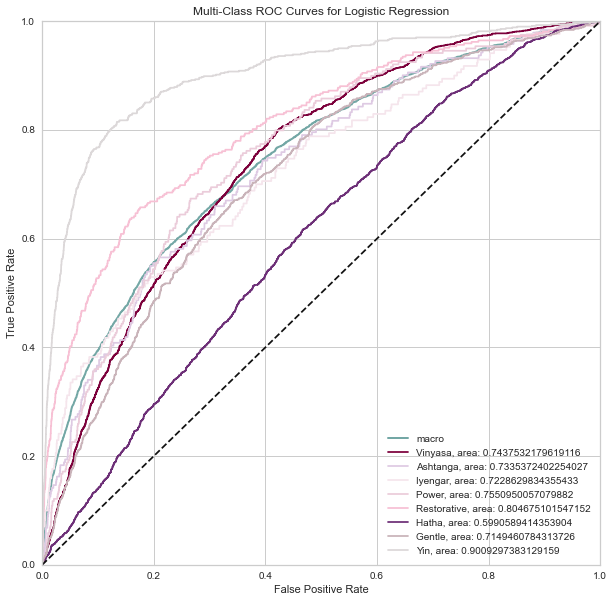

Subset of Data:


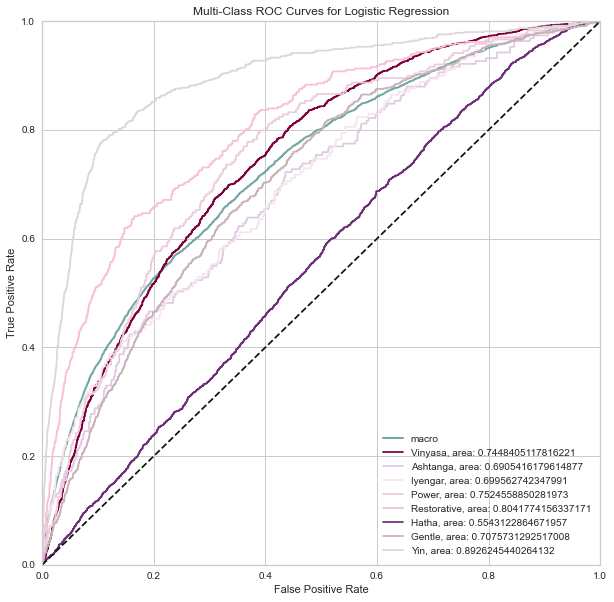

 
All Data:


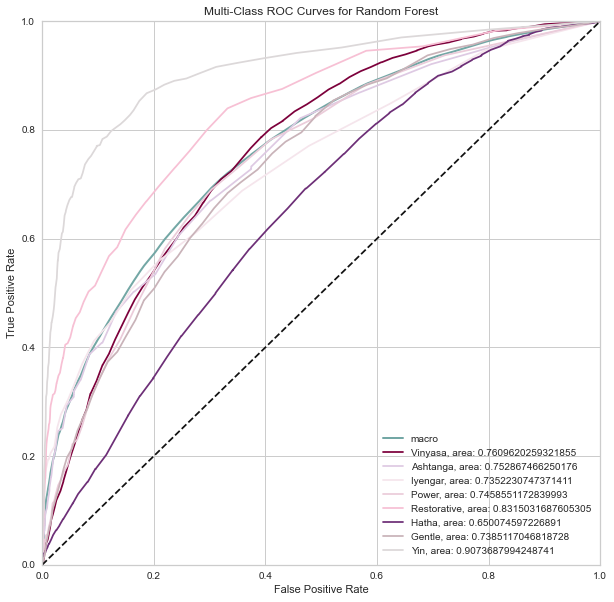

Subset of Data:


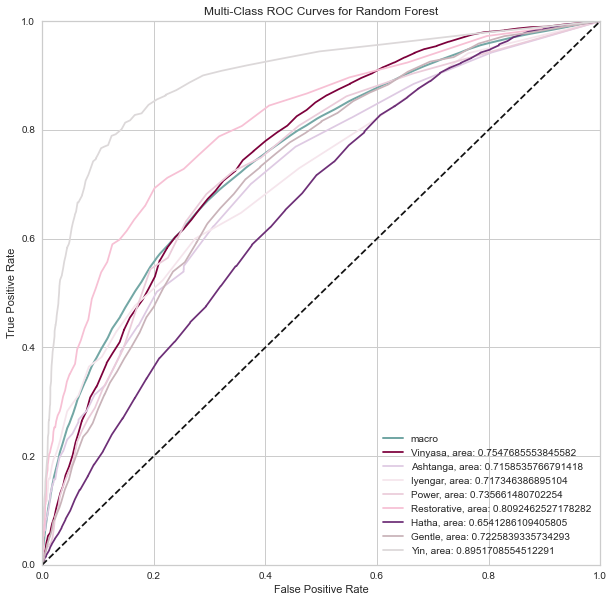

In [88]:
for model_name, model in models.items():
    if model_name == "Logistic Regression":
        print("All Data:")
        roc_curve_pipeline(X_train_scaled, y_train, model_name, model, RandomOverSampler(random_state=42))
        print("Subset of Data:")
        roc_curve_pipeline(X_train_2_scaled, y_train, model_name, model, RandomOverSampler(random_state=42))
        print(" ")
    else:
        print("All Data:")
        roc_curve_pipeline(X_train, y_train, model_name, model, RandomOverSampler(random_state=42))
        print("Subset of Data:")
        roc_curve_pipeline(X_train_2, y_train, model_name, model, RandomOverSampler(random_state=42))

The ROC-AUC curves and classification reports that it is not beneficial to feature engineer to just a subset of data. The recall of Hatha is reduced, at the expense of a reduction in recall and AUC of all classes. Not worth it. 

# Model Selection 

### Performance
After all of this tuning and adjusting, the optimal model is clear. I am ready to throw out Random Forest, since its recall on minority classes, no matter what, is just too low. 

Logistic Regression on the other hand, with solver="saga", has done extremely well at correctly classifying all class types, getting high recall on minority classes, while maintaining pretty high precision across all classes. 

### Interpretability

In selecting my model, I care a great deal about interpretability. I not only want to accurately classify what genre each yoga class falls into, but gain an understanding of what aspects of a yoga class are important in deciding what genre it falls into -- for my own education and the education of the yoga teachers who will use this app. 

To this end, Logistic Regression is by far the most interpretable model. It gives not only overall feature importances, but also in what direction (positive or negative) it is influencing the model. 

### Selection 

Logistic Regression it is! Sometimes simple is best. :) 

# Threshold Tuning
The final adjustment I want to make to my best model is adjusting its probability threshold, to explicitly define the trade-off between precision and recall for each class. This can be the final adjustment to help my class imbalance and optimize performance for my purposes. 

In [123]:
def threshold_tuning(X, y, model, threshold):

    y = label_binarize(y, classes=['Vinyasa', 'Ashtanga', 'Iyengar', 'Power', 'Restorative', 'Hatha',
                                   'Gentle', 'Yin'])
    n_classes = y.shape[1]

    # train-val split and oversample
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=.2, random_state=0)
    X_oversampled_train, y_oversampled_train = RandomOverSampler(random_state=42).fit_sample(
        X_train, y_train)

    # instantiate One vs. Rest Classifier, which allows for use
    model = OneVsRestClassifier(model)

    # fit model and predict probabilities of validation data being in each class
    model.fit(X_oversampled_train, y_oversampled_train)
    y_pred = (model.predict_proba(X_val) > threshold)
    
    # scores for each class 
    precision = dict()
    recall = dict()
    f1score = dict()
    for i in range(n_classes):
        precision[i], recall[i], f1score[i], _ = score(y_val[:, i], y_pred[:, i])
    
    classes = ['Vinyasa', 'Ashtanga', 'Iyengar', 'Power', 'Restorative', 'Hatha', 'Gentle', 'Yin']
         
    print("Threshold: ", threshold)
    for i in range(n_classes):
        print(classes[i], "precision: {}, recall: {}, f1: {}".format(precision[i][1], recall[i][1], f1score[i][1]))
        print(" ")
              

In [124]:
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in thresholds:
    threshold_tuning(X_train, y_train, LogisticRegression(max_iter=1000, solver="saga"), i)

Threshold:  0.05
Vinyasa precision: 0.35099, recall: 0.35099, f1: 0.35099
Ashtanga precision: 0.03352, recall: 0.03352, f1: 0.03352
Iyengar precision: 0.02887, recall: 0.02887, f1: 0.02887
Power precision: 0.05152, recall: 0.05152, f1: 0.05152
Restorative precision: 0.08803, recall: 0.08803, f1: 0.08803
Hatha precision: 0.31447, recall: 0.31447, f1: 0.31447
Gentle precision: 0.15269, recall: 0.15269, f1: 0.15269
Yin precision: 0.24834, recall: 0.24834, f1: 0.24834
Threshold:  0.1
Vinyasa precision: 0.42875, recall: 0.42875, f1: 0.42875
Ashtanga precision: 0.04559, recall: 0.04559, f1: 0.04559
Iyengar precision: 0.04088, recall: 0.04088, f1: 0.04088
Power precision: 0.06849, recall: 0.06849, f1: 0.06849
Restorative precision: 0.12283, recall: 0.12283, f1: 0.12283
Hatha precision: 0.33961, recall: 0.33961, f1: 0.33961
Gentle precision: 0.19340, recall: 0.19340, f1: 0.19340
Yin precision: 0.34209, recall: 0.34209, f1: 0.34209
Threshold:  0.2
Vinyasa precision: 0.58612, recall: 0.58612, f1

# Final Model

Logistic Regression, saga solver, RandomOverSampler to handle class imbalance.

Ultimately, after *all* of this, its basically just... Logistic Regression. Took a long time and a lot of trial to get back to square one. 

But hey, don't fix what isn't broken? 

### Evaluating Performance on Hold Out Data

In [132]:
final_model = LogisticRegression(max_iter=1000, solver="saga")

X_oversampled_train, y_oversampled_train = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)

final_model.fit(X_oversampled_train, np.array(y_oversampled_train).ravel())
y_pred = final_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Ashtanga       0.09      0.28      0.14       262
      Gentle       0.28      0.39      0.33      1093
       Hatha       0.47      0.13      0.21      2518
     Iyengar       0.11      0.44      0.18       222
       Power       0.11      0.53      0.18       279
 Restorative       0.27      0.43      0.34       484
     Vinyasa       0.50      0.23      0.32      2500
         Yin       0.53      0.64      0.58       876

    accuracy                           0.29      8234
   macro avg       0.30      0.38      0.28      8234
weighted avg       0.41      0.29      0.30      8234



### Visualizing Percentage of Actuals Captured

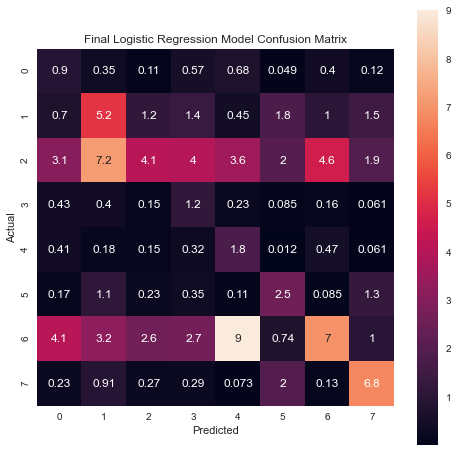

In [133]:
make_heatmap(y_test, y_pred, "Final Logistic Regression Model")

# Feature Importance

So yoga teachers can know what makes their class a certain genre! 

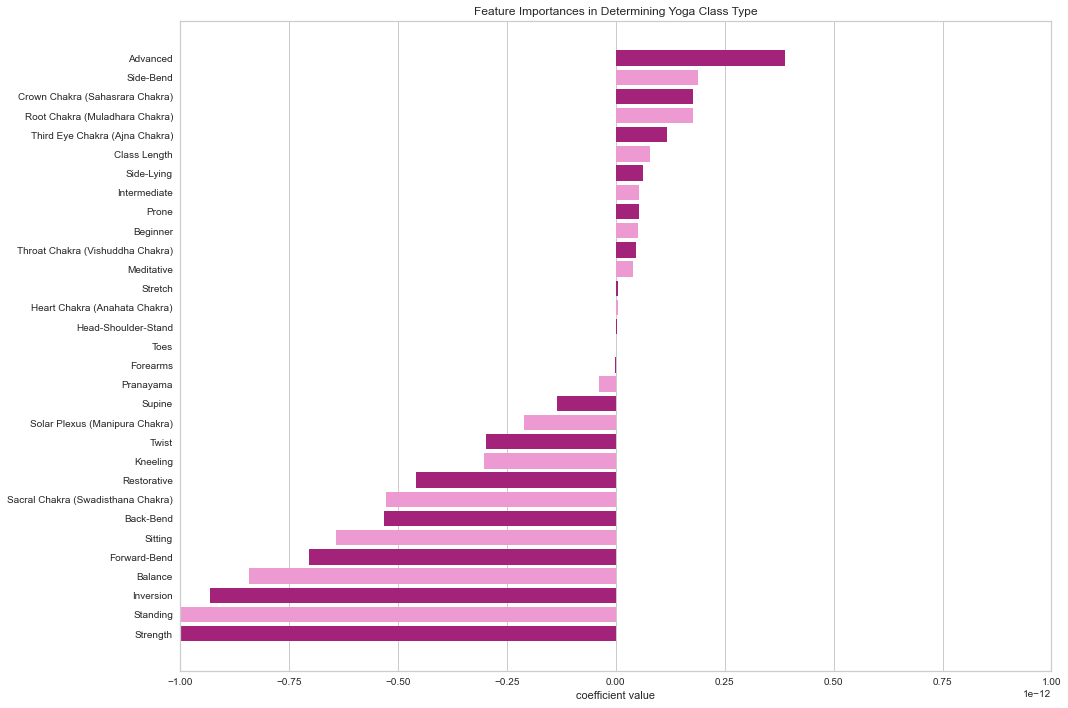

In [176]:
figure(num=None, figsize=(15, 10), facecolor='w')

my_title = "Feature Importances in Determining Yoga Class Type"
visualizer = FeatureImportances(final_model, title=my_title, colors=["#A22379", "#ED9AD2"], relative=False)
visualizer.fit(X_train, y_train)

visualizer.show()
for label in visualizer.ax.texts:
    label.set_size(20);

# Flask App
### Retraining on All Data
(Train and test combined, or, just back to X and y.) 

In [136]:
X_oversampled, y_oversampled = RandomOverSampler(random_state=0).fit_sample(X, y)

final_model.fit(X_oversampled, np.array(y_oversampled).ravel())

LogisticRegression(max_iter=1000, solver='saga')

### Preparing for Predicting on New Data

In [137]:
final_model.feature_names = df.columns[1:-1]
final_model.feature_names

Index(['Class Length', 'Back-Bend', 'Balance', 'Forward-Bend', 'Inversion',
       'Meditative', 'Pranayama', 'Restorative', 'Side-Bend', 'Strength',
       'Stretch', 'Twist', 'Beginner', 'Intermediate', 'Advanced', 'Forearms',
       'Head-Shoulder-Stand', 'Kneeling', 'Prone', 'Side-Lying', 'Sitting',
       'Standing', 'Supine', 'Toes', 'Crown Chakra (Sahasrara Chakra)',
       'Heart Chakra (Anahata Chakra)', 'Root Chakra (Muladhara Chakra)',
       'Sacral Chakra (Swadisthana Chakra)', 'Solar Plexus (Manipura Chakra)',
       'Third Eye Chakra (Ajna Chakra)', 'Throat Chakra (Vishuddha Chakra)'],
      dtype='object')

In [138]:
final_model.target_names = df["Class Type"].unique()
final_model.target_names

array(['Vinyasa', 'Ashtanga', 'Iyengar', 'Power', 'Restorative', 'Hatha',
       'Gentle', 'Yin'], dtype=object)

In [153]:
test_input = np.random.rand(1, 31)
final_model.predict(test_input)

array(['Ashtanga'], dtype=object)

### Pickling

In [155]:
f = open("final_model", "wb")
pickle.dump(final_model, f)
f.close()